/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/jumpy.py:70: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat_args, _ = jax.tree_flatten(a)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/physics/base.py:191: UserWarning: dynamics_mode either not specified or not recognized, defaulting to "pbd".  If you wish to preserve legacy behavior used in previous versions of Brax, set dynamics_mode="legacy_spring".
  warnings.warn(
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/carl/envs/mario/__init__.py:7: UserWarning: Could not load CARLMarioEnv which is probably not installed (No module named 'cv2').
  warnings.

Text(0, 0.5, 'loss')

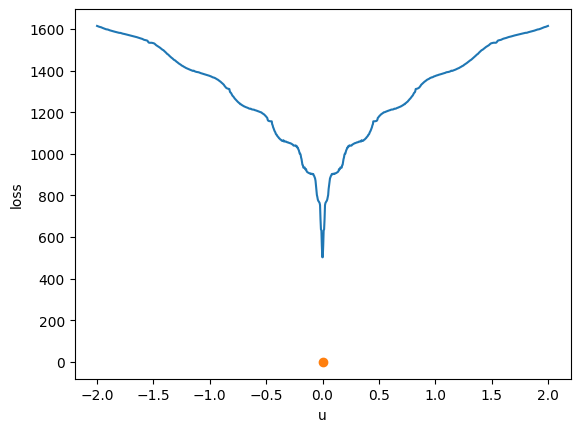

In [1]:
from carl.envs import CARLPendulumEnv, CARLPendulumEnv_bounds, CARLPendulumEnv_defaults
from gym.envs.classic_control.pendulum import angle_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

context = CARLPendulumEnv_defaults
max_speed = context["max_speed"]
max_torque = 2  # context["max_torque"]
m = context["m"]
l = context["l"]
g = context["g"]
dt = context["dt"]

thdot = 0
th = -0.25 * np.pi
u = 0

# copied from Pendulum
def loss(u, step: int = 0, max_steps: int = 200, th: float = 0, thdot: float = 0) -> float:
    costs = 0
    for i in range(max_steps - step):
        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        newthdot = np.clip(newthdot, -max_speed, max_speed)
        newth = th + newthdot * dt
        cost = angle_normalize(newth) ** 2 + 0.1 * newthdot**2 + 0.001 * (u**2)
        costs += cost
        th = newth
        thdot = newthdot
    return costs

# constraint = (-max_torque <= u <= max_torque)

X = np.linspace(-max_torque, max_torque, 1000)
Y = loss(X)
res_opt = minimize(loss, x0=0, bounds=[(-max_torque, max_torque)])
u_opt = res_opt.x[0]
plt.plot(X, Y)
plt.plot(u_opt, loss(u_opt), marker="o")
plt.xlabel("u")
plt.ylabel("loss")


In [2]:
from functools import partial
import pygame
import sys
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
pygame.display.init()


def pi_opt(s, context: dict, step: int = 0, *args, **kwargs):
    max_speed = context["max_speed"]
    max_torque = 2  # context["max_torque"]
    m = context["m"]
    l = context["l"]
    g = context["g"]
    dt = context["dt"]

    x, y, thdot = s
    th = np.arctan2(y, x)

    # assert np.isclose(x, np.cos(th)), f"{x} {np.cos(th)}"


    # def loss(u):
    #     newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
    #     newthdot = np.clip(newthdot, -max_speed, max_speed)
    #     newth = th + newthdot * dt
    #     cost = angle_normalize(newth) ** 2 + 0.1 * newthdot**2 + 0.001 * (u**2)
    #     return cost

    def loss(u, step: int = 0, max_steps: int = 200, th: float = 0, thdot: float = 0) -> float:
        costs = 0
        for i in range(max_steps - step):
            newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
            newthdot = np.clip(newthdot, -max_speed, max_speed)
            newth = th + newthdot * dt
            cost = angle_normalize(newth) ** 2 + 0.1 * newthdot**2 + 0.001 * (u**2)
            costs += cost
            th = newth
            thdot = newthdot
        return costs


    loss_fun = partial(loss, step=step, th=th, thdot=thdot)
    res_opt = minimize(loss_fun, x0=0, bounds=[(-max_torque, max_torque)])
    u_opt = res_opt.x[0]
    return u_opt


env = CARLPendulumEnv()
# env.render_mode = "rgb_array"
s = env.reset()
done = False
R = []
frames = []
counter = 0
policy = []
states = []
while not done:
    a = pi_opt(s, step=counter, context=context)
    s, r, done, info = env.step([a])
    frame = env.render(mode="rgb_array")
    counter += 1
    R.append(r)
    frames.append(frame)
    policy.append(a)
    states.append(s)
env.close()

print(len(R), np.sum(R), R[-1])

200 -1041.6012379749047 -0.007193128868801377


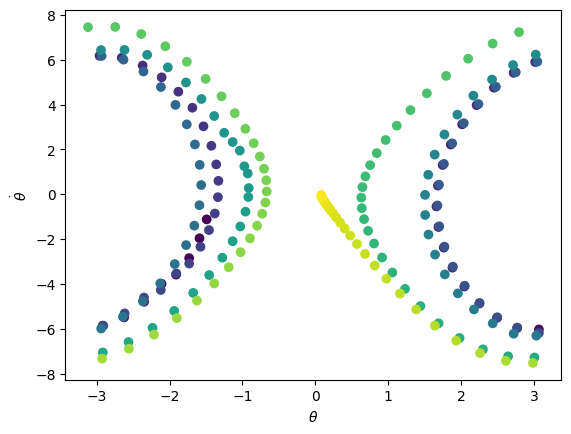

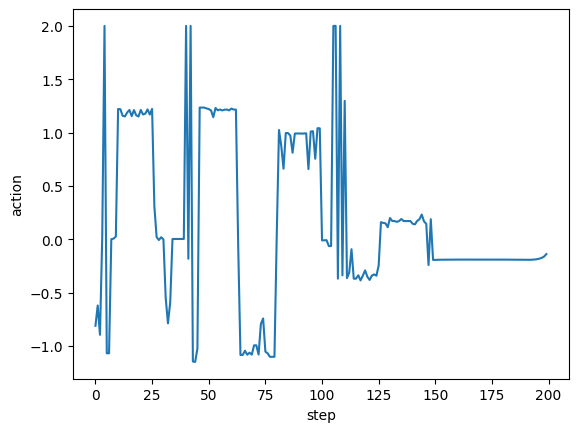

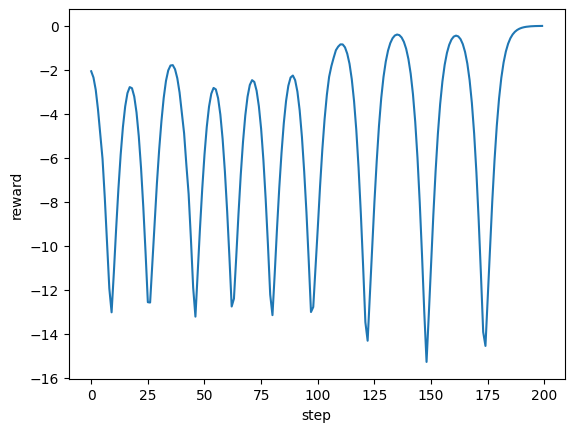

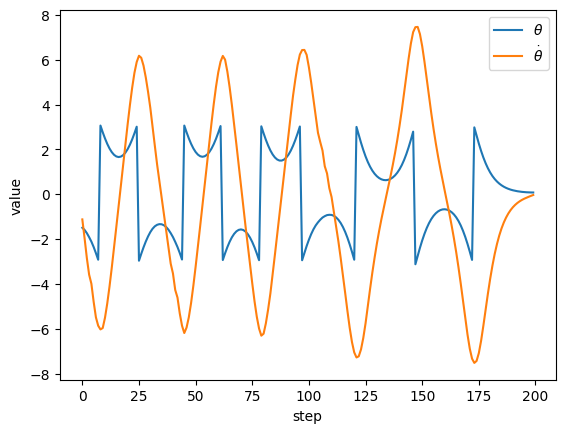

In [3]:
steps = np.arange(0, len(policy))
states = np.array(states)
ths = np.arctan2(states[:, 1], states[:, 0])
thdots = states[:, 2]

plt.scatter(ths, thdots, c=steps)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot\theta$")
plt.show()

plt.plot(steps, policy)
plt.xlabel("step")
plt.ylabel("action")
plt.show()

plt.plot(steps, R)
plt.xlabel("step")
plt.ylabel("reward")
plt.show()

plt.plot(steps, ths, label=r"$\theta$")
plt.plot(steps, thdots, label=r"$\dot\theta$")
plt.xlabel("step")
plt.ylabel("value")
plt.legend()
plt.show()


In [4]:
from PIL import Image
from pathlib import Path

fp_out = Path("tmp/pendulum_optimal_agent.gif")
fp_out.parent.mkdir(parents=True, exist_ok=True)


# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = iter([Image.fromarray(f) for f in frames])
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1/30, loop=0)

In [36]:
from smac import BlackBoxFacade, Scenario

from ConfigSpace import Configuration, ConfigurationSpace, Float


# PID Controller
def control(u, e_2, e_1, e_0, K_p, Ti, Td):
    u = u + K_p * ((1 + dt/Ti + Td/dt) * e_2 + (-1 - 2*Td / dt) * e_1 + Td / dt * e_0)
    u = np.clip(u, -max_torque, max_torque)
    return u


def pi_opt(s, context: dict, step: int = 0, *args, **kwargs):
    max_speed = context["max_speed"]
    max_torque = 2  # context["max_torque"]
    m = context["m"]
    l = context["l"]
    g = context["g"]
    dt = context["dt"]

    x, y, thdot = s
    th = np.arctan2(y, x)

    def loss(u, step: int = 0, max_steps: int = 200, th: float = 0, thdot: float = 0) -> float:
        costs = 0
        for i in range(max_steps - step):
            newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
            newthdot = np.clip(newthdot, -max_speed, max_speed)
            newth = th + newthdot * dt
            cost = angle_normalize(newth) ** 2 + 0.1 * newthdot**2 + 0.001 * (u**2)
            costs += cost
            th = newth
            thdot = newthdot
        return costs


    loss_fun = partial(loss, step=step, th=th, thdot=thdot)
    res_opt = minimize(loss_fun, x0=0, bounds=[(-max_torque, max_torque)])
    u_opt = res_opt.x[0]
    return u_opt


th_target = 0
thdot_target = 0
target = np.array([th_target, thdot_target])


def transform_state(s):
    return np.array(np.arctan2(s[1], s[0]), s[2])

K_p = 2
Ti = 1
Td = 1

def target_function(x: list | np.ndarray | tuple | dict | Configuration, seed: int | None = None):
    if type(x) == np.ndarray or type(x) == list or type(x) == tuple:
        K_p, Ti, Td = x
    elif type(x) == dict or type(x) == Configuration:
        K_p = x["K_p"]
        Ti = x["Ti"]
        Td = x["Td"]
    else:
        raise ValueError("Unknown input type", type(x))
    env = CARLPendulumEnv()
    s = env.reset()
    a = 0
    done = False
    R = []
    frame = None
    frames = []
    counter = 0
    policy = []
    states = []
    states_queue = []
    while not done:
        states_queue.append(s)
        if len(states_queue) > 3:
            states_queue.pop(0)
        s = np.array(s)
        th = np.arctan2(s[1], s[0])
        thdot = s[2]
        e_2 = (th_target - th, thdot_target - thdot)
        e_1 = 0
        e_0 = 0
        if len(states_queue) == 3:
            s_0, s_1, s_2 = states_queue
            e_2 = target - transform_state(s_2)
            e_1 = target - transform_state(s_1)
            e_0 = target - transform_state(s_0)
        
        a = control(a, e_2=0, e_1=0, e_0=0, K_p=K_p, Ti=Ti, Td=Td)
        # a = pi_opt(s, step=counter, context=context)
        s, r, done, info = env.step([a])
        # frame = env.render(mode="rgb_array")
        frames.append(frame)
        counter += 1
        R.append(r)
        policy.append(a)
        states.append(s)
    env.close()
    return -np.sum(R)  # negate because we want to maximize rewards but SMAC minimizes

x = 2, 1, 2
cumR = target_function(x=x)


res_opt = minimize(target_function, x0=[1,1,1])
print(target_function(res_opt.x))





cs = ConfigurationSpace(seed=0)
x0 = Float("K_p", (1e-5, 10), default=1)
x1 = Float("Ti", (1e-5, 10), default=0.5)
x2 = Float("Td", (0, 10), default=0.5)
cs.add_hyperparameters([x0, x1, x2])
configspace = cs

scenario = Scenario(configspace, name="synthetic_function", n_trials=2000)
smac = BlackBoxFacade(
            scenario,
            target_function, 
            overwrite=True,
            initial_design=BlackBoxFacade.get_initial_design(scenario=scenario, n_configs=1000)  
        )

incumbent = smac.optimize()

1319.9470729891464
[INFO][abstract_initial_design.py:68] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:81] Reducing the number of initial configurations from 1000 to 200 (max_ratio == 0.1).
[INFO][abstract_initial_design.py:133] Using 200 initial design and 0 additional configurations.
[INFO][intensifier.py:275] No incumbent provided in the first run. Sampling a new challenger...
[INFO][intensifier.py:446] First run and no incumbent provided. Challenger is assumed to be the incumbent.
[INFO][intensifier.py:566] Updated estimated cost of incumbent on 1 trials: 1460.4108
[INFO][intensifier.py:566] Updated estimated cost of incumbent on 2 trials: 1419.0693
[INFO][abstract_intensifier.py:340] Challenger (958.6559) is better than incumbent (1419.0693) on 2 trials.
[INFO][abstract_intensifier.py:364] Changes in incumbent:
[INFO][abstract_intensifier.py:367] --- K_p: 2.6687925419136325 -> 5.327040150349447
[INFO][abstract_intensifier.py:367] 

In [28]:
print(len(list(smac.runhistory.values())))
smac.incumbent

300


Configuration(values={
  'K_p': 8.28389724114033,
  'Td': 0.5862905888377212,
  'Ti': 2.0017148137988707,
})